In [81]:
'''
=============================================================================
Strain_to_Spectrogram.py

Load AP Sensing converted nanostrain .npy files and save as a list for indexing 
For one selected channel only
Taper and filter
Convert to strain rate
Plot Spectrogram
=============================================================================
'''

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon 15 July 2024

@author: em
"""

'''
=============================================================================
# Section 1: Data Load for Next Steps: Create a list to index of .npy arrays
=============================================================================
'''
from obspy import read
import datetime
import os, h5py, glob
import numpy as np
from numpy import asarray
from numpy import savetxt
import scipy.signal 
from scipy.signal import welch
import scipy.io as sio
import multiprocessing as mp
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt,find_peaks
from scipy.signal import butter, filtfilt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from scipy.signal import spectrogram
from obspy import read
from datetime import datetime, timedelta
from matplotlib.colors import LogNorm  
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter

channel = 900 

#res_arrays will be a list containing all the loaded numpy arrays from res1 to res32
#access each array by indexing into the list, e.g., res_arrays[0] for res1, res_arrays[1] for res2, and so on.
    
# Define the directory where the files are stored
directory = '/Users/em/PROJECTS/OREX/DATA/'

# Initialize a list to store the loaded arrays
res_arrays = []

# Loop over the range of numbers from 1 to 32
for i in range(1, 32):
    # Construct the file path
    file_path = f'{directory}res{i}_{channel}.npy'
    
    # Load the array
    res = np.load(file_path)
    
    # Append the loaded array to the list
    res_arrays.append(res)

# Now, res_arrays contains all the loaded arrays from res1 to res32    

'''
=============================================================================
# Section 2: Table of Indices to Times. Create a list to index of .npy arrays
=============================================================================
'''
import pandas as pd

# file path to csv with array number in col 1; local time in col 2
file_path = '/Users/em/PROJECTS/OREX/DATA/res_time.csv'

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

print(df)

'''
=============================================================================
# Section 3: Pre-processing: Taper and Filter
=============================================================================
'''
# define filter and taper in pre-processing
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs #for fs = 500
    low = lowcut / nyq 
    high = highcut / nyq 
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def taper(x,p):
    if p <= 0.0:
        return x
    else:
        f0 = 0.5
        f1 = 0.5
        n  = len(x)
        nw = int(p*n)

        if nw > 0:
            ow = np.pi/nw

            w = np.ones( n )
            for i in range( nw ):
                w[i] = f0 - f1 * np.cos(ow*i)

            for i in range( n-nw,n ):
                w[i] = 1.0 - w[i-n+nw]

            return x * w
        elif nw == 0:
            return x

print("definitions complete")

# bandpass
filt = [7,30] # filt used to lowcut and highcut from 7 to 30 Hz
#filt = [1,10] # filt used to lowcut and highcut from 1 to 10 Hz
#filt = [30,50] # filt used to lowcut and highcut from 30 to 50 Hz
#filt = [8,90] # filt used to lowcut and highcut from 8 to 90 Hz
delta = 500 # Data Rate ; cutoff = 220
res = []

# Loop over res_arrays from index 0 to 31 (32 arrays in total)
for i in range(len(res_arrays)):
    # Apply taper function
    res_array = taper(res_arrays[i], 0.01)
    
    # Apply butter_bandpass_filter function
    res_array = butter_bandpass_filter(res_array, lowcut=filt[0], highcut=filt[1], fs=delta, order=4)
    
    # Update the array in the res_arrays list
    res_arrays[i] = res_array
    
    # Now res_arrays[0] to res_arrays[31] have been processed with taper and butter_bandpass_filter functions
   
print("tapered bandpassed")


'''
=============================================================================
# Section 4: Strain to Strain Rate
=============================================================================
'''
# strain to strain rate, strain derivative with respect to time, 0.002 s time step
fs = 500  # Sampling frequency in Hz
t = 0.002 # 1/frequency sampling rate, 500 Hz

# Take first derivative with respect to time of strain data = strain rate (s^1)
# Loop over res_arrays from index 0 to 31 (32 arrays in total)
for i in range(len(res_arrays)):

    res_array = np.gradient(res_arrays[i], t) #res_s = np.gradient(res, t
    
    # Update the array in the res_arrays list
    res_arrays[i] = res_array

print("strain to strain rate complete")

'''    
=============================================================================
# Section 5: Filter out non-positive values- take absolute value?
 =============================================================================
'''

# filter out non-positive values--not sure if this should be done.
# Loop over res_arrays from index 0 to 31 (32 arrays in total)
for i in range(len(res_arrays)):

    res_array = np.abs(res_arrays[i]) #res_s = np.abs(res_s)
    
    # Update the array in the res_arrays list
    res_arrays[i] = res_array

print("absolute value complete; concatonating abs(strain rate) into array for spectra")

'''    
=============================================================================
# Section 6: Concatonate indexed res_arrays list into a single array 
 =============================================================================
'''
#
# Concatenate all arrays into a single array
concat_res_all = np.concatenate(res_arrays[1:], axis=0)

# Concatenate all arrays into a single array
#concat_res_all = np.concatenate(res_arrays, axis=0) #Error: name 'concat_res_s_all' is not defined

# save concatenated array variable
#np.savetxt('/Users/em/PROJECTS/OREX/VAR/concat_res_s_all.txt', concat_res_s_all)
#np.save('/Users/em/PROJECTS/OREX/VAR/concat_res_s_all.npy', concat_res_s_all)

print("strain rate abs value concatonated array saved; calculating spectra")


    res_arrays_xx  Local_time
0               0         546
1               1         551
2               2         556
3               3         601
4               4         606
5               5         611
6               6         616
7               7         621
8               8         626
9               9         631
10             10         636
11             11         641
12             12         646
13             13         651
14             14         656
15             15         701
16             16         706
17             17         711
18             18         716
19             19         721
20             20         726
21             21         731
22             22         736
23             23         741
24             24         746
25             25         751
26             26         756
27             27         801
28             28         806
29             29         811
30             30         816
31             31         821
definition

In [82]:
'''    
=============================================================================
# Section 7: Calculate the spectra (multiple variations)
 =============================================================================
'''

#Calculate the spectrogram, alter window length, overlap, and log-scale PSD range in legend

# Length of each segment
nperseg = 1024  # nperseg_values = [2048, 4096, 8192]
#noverlap = nperseg // 2 # Set overlap to 50% of the segment length
noverlap = 3 * nperseg // 4 # Set overlap to 75% of the segment length

# Compute the spectra with the specified overlap
frequencies, times, Sxx = spectrogram(concat_res_all, fs, nperseg=nperseg, noverlap=noverlap)

# Gaussian filter option
#sigma = 2  # Standard deviation for the Gaussian 
#Sxx_smoothed = gaussian_filter(Sxx, sigma=sigma)

# Savitzky-Golay filter option
#Sxx_smoothed = savgol_filter(Sxx, window_length=5, polyorder=2, axis=1)

# Normalize the PSD values relative to the median
median_Sxx = np.median(Sxx) #use for non-smoothed
#median_Sxx = np.median(Sxx_smoothed) #use for smoothing filters
Sxx_normalized = Sxx - median_Sxx
Sxx_normalized[Sxx_normalized < 0] = 0  # Ensure no negative values
Sxx_log = 10 * np.log10(Sxx_normalized + 1e-10)  # Add a small value to avoid log(0)
Sxx_log2 = 10* np.log10(Sxx + 1e-10) # not normalized, but 10log10

print("spectra calculated; plotting spectrogram")

# Datetime stuff
start_time = datetime.strptime('05:46', '%H:%M') #see .csv forstimes; # Define the start time (06:26)
time_labels = [start_time + timedelta(seconds=t) for t in times] # Create a list of datetime objects for the x-axis

print("dateformat complete")

spectra calculated; plotting spectrogram
dateformat complete


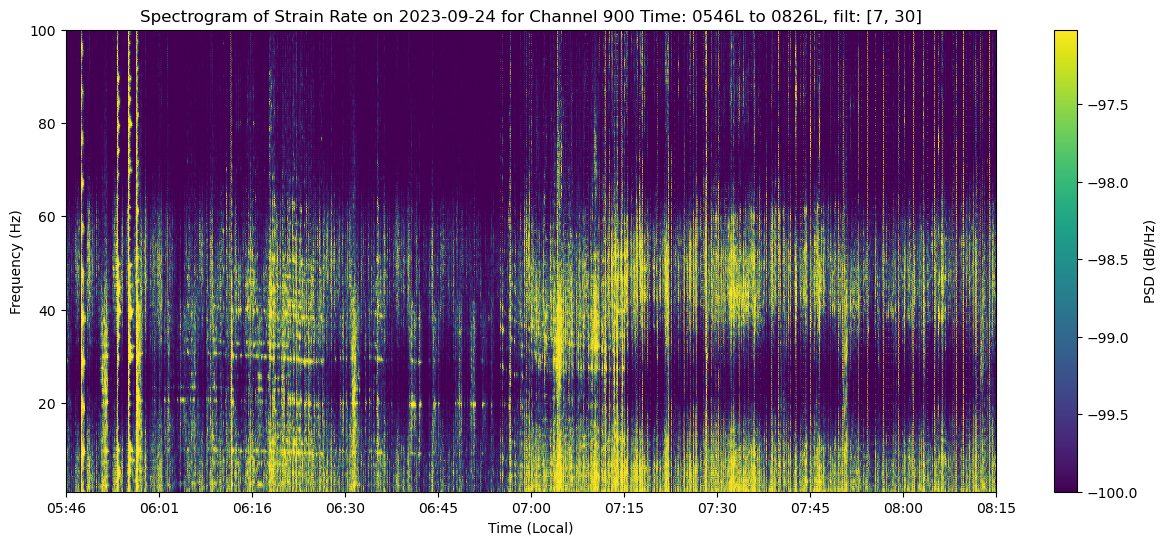

In [83]:
'''    
=============================================================================
# Section 8: Plot the spectrogram 
 =============================================================================
'''

# Step 2: Plot the spectrogram
plt.figure(figsize=(15, 6))
plt.pcolormesh(times, frequencies, Sxx_log, shading='gouraud', cmap='viridis') #norm rel med 10log10; 
#gouraud smoother appearance by interpolating colors between the grid points; #cmap='seismic' ;cmap = 'plasma'
plt.colorbar(label='PSD (dB/Hz)')
plt.ylabel('Frequency (Hz)')
#plt.xlabel('Time (s)')
plt.xlabel('Time (Local)')
plt.ylim(1, 100)
#plt.yscale('log')  # Set y-axis to logarithmic scale; doesn't plot correctly- because it's alread 10log10?
plt.title(f"Spectrogram of Strain Rate on {mth_day} for Channel {channel} Time: 0546L to 0826L, filt: {filt}")
#plt.title(f"Spectrogram of Strain Rate on {mth_day} for Channel {channel} Time: 0546L to 0826L, filt: {filt}")
#plt.title(f"Spectrogram of Strain Rate on {mth_day} for Channel {channel} Time: 0546L to 0826L, no filt")

# Update the x-axis to show time in HH:MM format
plt.xticks(times[::len(times)//10], [time.strftime('%H:%M') for time in time_labels[::len(times)//10]])

# Set color scale limits to improve contrast
plt.clim(np.percentile(Sxx_log, 5), np.percentile(Sxx_log, 95))

# Save the plot as a high-resolution .jpg file
plt.savefig('/Users/em/PROJECTS/OREX/FIGS/spectrogramSunrise_0546to0826_filt7to30_4076_75_SG.png', format='png', dpi=300, bbox_inches='tight')

plt.show()